In [201]:
from feature_extraction import get_all_features
from classification import *
from visualisation import plot2D, show_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [202]:
features_raw, labels = get_all_features("results")
scaler = StandardScaler()
features = scaler.fit_transform(features_raw)

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# All Features

In [203]:
import numpy as np
X_2d = reduce_dimensionality_UMAP(features, 10)
#X_2d = reduce_dimensionality_VAE(features, latent_dim=10, epochs=50)
plot2D(X_2d, labels)

c:\Users\sokol\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


              precision    recall  f1-score   support

     chicken       0.85      0.82      0.84       343
    gelatine       0.89      0.94      0.91       406
    zucchini       0.91      0.89      0.90       429

    accuracy                           0.89      1178
   macro avg       0.89      0.88      0.88      1178
weighted avg       0.89      0.89      0.89      1178



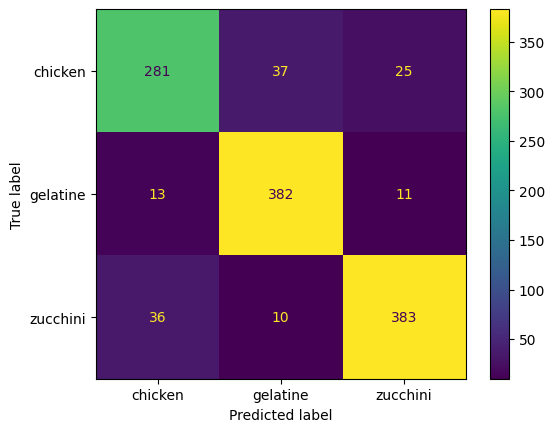

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X_2d, labels, test_size=0.3, random_state=42, stratify=labels)
clf = fit_classifier(X_train, y_train, 3)
y_pred = evaluate_classifier(clf, X_test, y_test)
show_confusion_matrix(y_pred, y_test, display_labels=clf.classes_)

In [205]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_clusters(X_2d, labels, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_2d)

    df = pd.DataFrame({'Cluster': cluster_labels, 'Class': labels})
    print(df.groupby(['Cluster', 'Class']).size().unstack(fill_value=0))

    sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=cluster_labels, palette='tab10')
    plt.title("Clusters detected by KMeans")
    plt.show()


Class    chicken  gelatine  zucchini
Cluster                             
0            249       444        66
1            312       347       288
2            582       561      1075


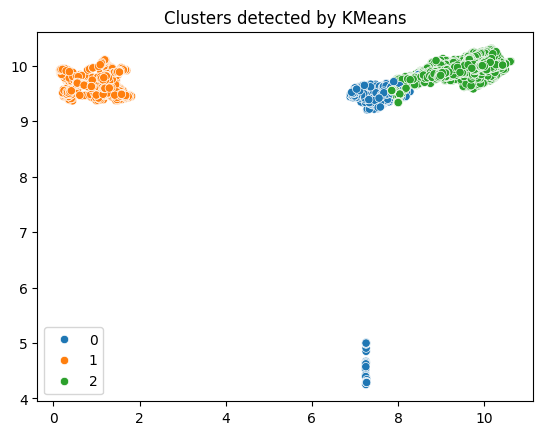

In [206]:
analyze_clusters(X_2d, labels, n_clusters=3)

In [207]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(features, labels_encoded) 

importances = clf.feature_importances_

plt.figure(figsize=(10,4))
plt.bar(range(len(importances)), importances)
plt.title("Ważność cech (RandomForest)")
plt.xlabel("MFCC cecha")
plt.ylabel("Ważność")
plt.show()


In [208]:
import pandas as pd
import numpy as np

df = pd.DataFrame(features, columns=[f"MFCC_{i}" for i in range(features.shape[1])])
df["UMAP1"] = X_2d[:, 0]
df["UMAP2"] = X_2d[:, 1]

correlations = df.corr()[["UMAP1", "UMAP2"]].drop(index=["UMAP1", "UMAP2"])
# print(correlations.sort_values("UMAP1", ascending=False))


In [209]:
# Najbardziej istotne cechy w ujęciu absolutnym (zarówno dodatnie, jak i ujemne)
correlations["abs_corr"] = correlations["UMAP1"].abs() + correlations["UMAP2"].abs()
top_features = correlations.sort_values("abs_corr", ascending=False).head(15)
# print(top_features)


# Select 5 most important

In [210]:
from sklearn.feature_selection import f_classif

f_values, p_values = f_classif(features, labels_encoded)

# Zbuduj DataFrame z wynikami
f_df = pd.DataFrame({
    "feature": [f"MFCC_{i}" for i in range(features.shape[1])],
    "f_value": f_values,
    "p_value": p_values
})

# Sortuj od najbardziej znaczących cech
top_features = f_df.sort_values("f_value", ascending=False)
print(top_features.head(20))


    feature      f_value       p_value
1    MFCC_1  1614.074341  0.000000e+00
3    MFCC_3   965.796326  0.000000e+00
5    MFCC_5   659.074463  0.000000e+00
8    MFCC_8   512.180603  0.000000e+00
10  MFCC_10   460.480560  0.000000e+00
17  MFCC_17   446.105011  0.000000e+00
19  MFCC_19   213.244095  0.000000e+00
2    MFCC_2   182.216873  0.000000e+00
6    MFCC_6   170.619003  0.000000e+00
13  MFCC_13   101.779404  8.127531e-44
15  MFCC_15    56.363140  7.363154e-25
11  MFCC_11    56.107986  9.435953e-25
4    MFCC_4    45.503513  2.910221e-20
14  MFCC_14    26.210529  4.924161e-12
7    MFCC_7    25.695108  8.189403e-12
12  MFCC_12    24.720518  2.143573e-11
16  MFCC_16    22.485397  1.951154e-10
9    MFCC_9    16.700647  5.994035e-08
0    MFCC_0    12.594645  3.529474e-06
18  MFCC_18     3.930461  1.971203e-02


In [211]:
selected_cols = top_features.head(5)["feature"].tolist()
X_selected = df[selected_cols].values

In [212]:
X_umap = reduce_dimensionality_UMAP(X_selected, 15)
#X_2d = reduce_dimensionality_VAE(features, latent_dim=10, epochs=50)
plot2D(X_umap, labels)

c:\Users\sokol\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


              precision    recall  f1-score   support

     chicken       0.69      0.71      0.70       343
    gelatine       0.85      0.85      0.85       406
    zucchini       0.83      0.81      0.82       429

    accuracy                           0.80      1178
   macro avg       0.79      0.79      0.79      1178
weighted avg       0.80      0.80      0.80      1178



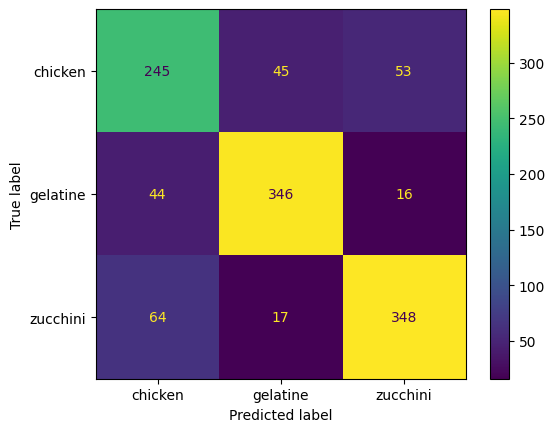

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X_umap, labels, test_size=0.3, random_state=42, stratify=labels)
clf = fit_classifier(X_train, y_train, 3)
y_pred = evaluate_classifier(clf, X_test, y_test)
show_confusion_matrix(y_pred, y_test, display_labels=clf.classes_)

In [214]:
analyze_clusters(X_umap, labels, n_clusters=3)

Class    chicken  gelatine  zucchini
Cluster                             
0            359      1203       116
1             62         1       893
2            722       148       420


### With denoising

In [215]:
features_raw, labels = get_all_features("results_denoised")
scaler = StandardScaler()
features = scaler.fit_transform(features_raw)

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [216]:
f_values, p_values = f_classif(features, labels_encoded)
df = pd.DataFrame(features, columns=[f"MFCC_{i}" for i in range(features.shape[1])])

# Zbuduj DataFrame z wynikami
f_df = pd.DataFrame({
    "feature": [f"MFCC_{i}" for i in range(features.shape[1])],
    "f_value": f_values,
    "p_value": p_values
})

# Sortuj od najbardziej znaczących cech
top_features = f_df.sort_values("f_value", ascending=False)
print(top_features.head(10))

selected_cols = top_features.head(9)["feature"].tolist()
X_selected = df[selected_cols].values

    feature      f_value       p_value
1    MFCC_1  1300.295044  0.000000e+00
5    MFCC_5   837.809570  0.000000e+00
3    MFCC_3   586.606262  0.000000e+00
17  MFCC_17   505.475983  0.000000e+00
10  MFCC_10   492.024414  0.000000e+00
8    MFCC_8   464.482574  0.000000e+00
6    MFCC_6   250.770996  0.000000e+00
2    MFCC_2   228.757401  0.000000e+00
19  MFCC_19   168.232010  0.000000e+00
11  MFCC_11   102.453751  3.783506e-44


In [217]:
X_umap = reduce_dimensionality_UMAP(X_selected, 15)
plot2D(X_umap, labels)

c:\Users\sokol\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


              precision    recall  f1-score   support

     chicken       0.77      0.76      0.77       363
    gelatine       0.87      0.91      0.89       416
    zucchini       0.88      0.85      0.87       455

    accuracy                           0.85      1234
   macro avg       0.84      0.84      0.84      1234
weighted avg       0.85      0.85      0.85      1234



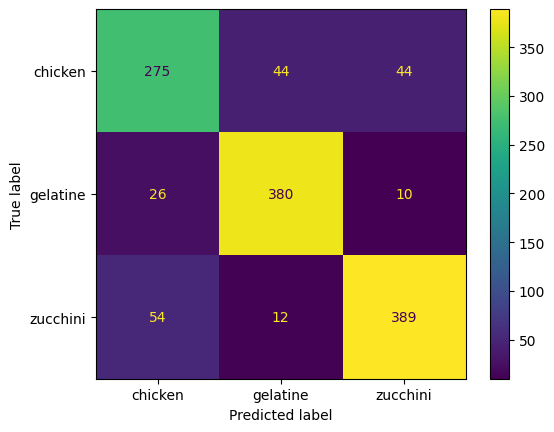

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X_umap, labels, test_size=0.3, random_state=42, stratify=labels)
clf = fit_classifier(X_train, y_train, 3)
y_pred = evaluate_classifier(clf, X_test, y_test)
show_confusion_matrix(y_pred, y_test, display_labels=clf.classes_)

In [219]:
analyze_clusters(X_umap, labels, n_clusters=3)

Class    chicken  gelatine  zucchini
Cluster                             
0            599      1104        90
1             52         0       994
2            558       282       434
